# Long Short Term Memory Networks for IoT Prediction

In [296]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers.core import Activation
from keras.utils import pad_sequences

In [349]:
######## loading data ###########
df = pd.read_csv('household_power_clean.csv')

####### training and validation sets #########
# assigning size for data subset
subset_size = int(len(df)*0.01)

# taking random data subset
df_subset = df.sample(subset_size, random_state=1)

#spliting data subset 80/20 for train/validation
train_df = df_subset.sample(frac=0.8, random_state=1)
val_df = df_subset.drop(train_df.index)

In [350]:
#reseting the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

# LSTM

In [351]:
# Initialize empty lists for sequences and their corresponding labels
seq_arrays = []
seq_labs = []

# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']

#Create list of sequence length GAP readings
for i in range(seq_length, len(train_df)-ph):
    # Create a sequence of length seq_length
    seq = []
    for col in feat_cols:
        seq.append(train_df.loc[i-seq_length:i-1, col].values)
    seq = np.stack(seq, axis=1)
    seq_arrays.append(seq)
    
    # Get the corresponding label (GAP measurement at predictive horizon)
    label = train_df.loc[i+ph, 'Global_active_power']
    seq_labs.append(label)

# Convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype=np.float32)
seq_labs = np.array(seq_labs, dtype=np.float32)

In [352]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [353]:
seq_arrays.shape

(16359, 30, 1)

Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?

A: 
To determine at runtime whether particular requirements are true. 
They are a means of detecting and fixing coding errors early on before they become more major issues later. We can write more reliable code with the aid of assertions.

Before advancing ahead, the assertions are used to make sure the data's shape is as anticipated. The code will produce an AssertionError and stop running if any of the assertions fail.

# MODEL TRAINING

In [354]:
# define path to save model
model_path = 'LSTM_model1.h5'

# build the network
nb_features = seq_arrays.shape[2]
nb_out = 1

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=30, #number of hidden units
         return_sequences=True))
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(
          units=15,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_72 (LSTM)              (None, 30, 30)            3840      
                                                                 
 dropout_72 (Dropout)        (None, 30, 30)            0         
                                                                 
 lstm_73 (LSTM)              (None, 15)                2760      
                                                                 
 dropout_73 (Dropout)        (None, 15)                0         
                                                                 
 dense_36 (Dense)            (None, 1)                 16        
                                                                 
 activation_36 (Activation)  (None, 1)                 0         
                                                                 
Total params: 6,616
Trainable params: 6,616
Non-train

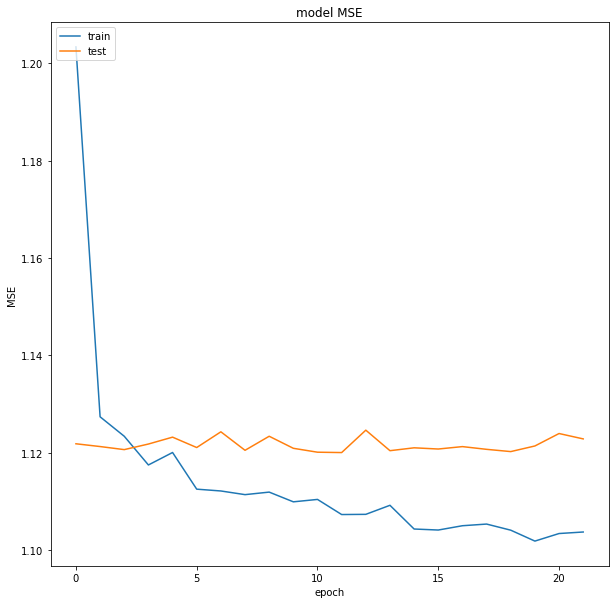

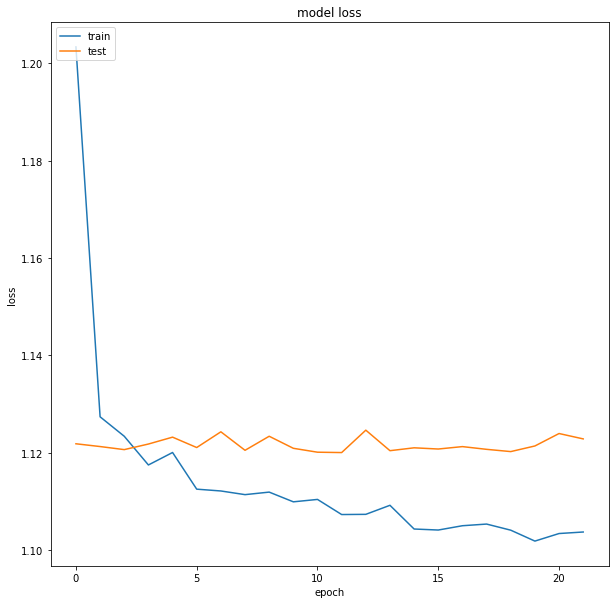

In [355]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")

# Validating our model

Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?

A:
It takes list of sequences as input and returns a numpy array of sequences.
pad_sequences is used to pad the input validation sequences to a fixed length of seq_length
The input validation sequences are created by looping through the validation dataset and creating a sequence of seq_length Global_active_power readings from the feat_cols list. 
The corresponding label is the Global_active_power reading ph steps into the future.
In our code the padding argument is set to 'post', which means that zeros will be added after the end of the original content to pad the sequence to the desired length.

In [356]:
val_arrays = []
val_labs = []

# create list of GAP readings starting with a minimum of two readings
for i in range(seq_length, len(val_df)-ph):
    seq = val_df[feat_cols].iloc[i-seq_length:i].to_numpy()
    val_arrays.append(seq)
    val_labs.append(val_df[feat_cols].iloc[i+ph]['Global_active_power'])
    
# use the pad_sequences function on your input sequences
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, dtype=np.float32, padding='post', truncating='post')

# convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

In [357]:
print(val_arrays.shape)

(4063, 30, 1)


127/127 - 1s - loss: 1.0585 - mse: 1.0585 - 568ms/epoch - 4ms/step

MSE: 1.0584807395935059
127/127 [==============================] - 1s 4ms/step


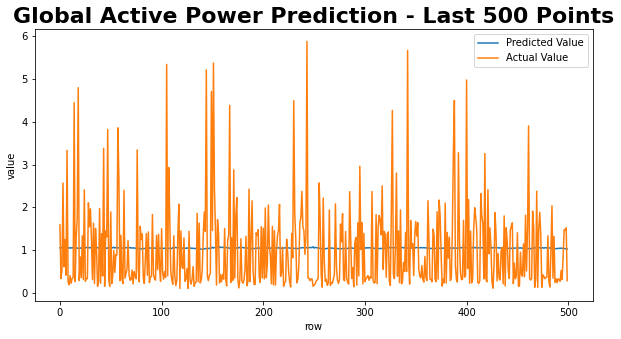

In [358]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?

A:
My model's predicted value is a straight line, however, it doesn't match the real value.
I've tried everything, but even though the model's architectural changes caused the loss curve to alter, the problem still occurs when the model is validated. I looked up the reason why this occurs online.
reasons:
Underfitting,
Overfitting,
Incorrect data preprocessing,
Insufficient training data,
and some Other factors.

# Model Optimization

Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?

A:
To deal with the errors, I am trying to increase the size of data subset and change the optimizer

In [375]:
######## loading data ###########
df = pd.read_csv('household_power_clean.csv')

####### training and validation sets #########
# assigning size for data subset
subset_size = int(len(df)*0.04)

# taking random data subset
df_subset = df.sample(subset_size, random_state=1)

#spliting data subset 80/20 for train/validation
train_df = df_subset.sample(frac=0.8, random_state=1)
val_df = df_subset.drop(train_df.index)

#reseting the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

In [376]:
# Initialize empty lists for sequences and their corresponding labels
seq_arrays = []
seq_labs = []

# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']

#Create list of sequence length GAP readings
for i in range(seq_length, len(train_df)-ph):
    # Create a sequence of length seq_length
    seq = []
    for col in feat_cols:
        seq.append(train_df.loc[i-seq_length:i-1, col].values)
    seq = np.stack(seq, axis=1)
    seq_arrays.append(seq)
    
    # Get the corresponding label (GAP measurement at predictive horizon)
    label = train_df.loc[i+ph, 'Global_active_power']
    seq_labs.append(label)

# Convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype=np.float32)
seq_labs = np.array(seq_labs, dtype=np.float32)


assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [381]:
# define path to save model
model_path = 'LSTM_model1.h5'

# build the network
nb_features = seq_arrays.shape[2]
nb_out = 1

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=30, #number of hidden units
         return_sequences=True))
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(
          units=10,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())


Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_88 (LSTM)              (None, 30, 30)            3840      
                                                                 
 dropout_88 (Dropout)        (None, 30, 30)            0         
                                                                 
 lstm_89 (LSTM)              (None, 10)                1640      
                                                                 
 dropout_89 (Dropout)        (None, 10)                0         
                                                                 
 dense_44 (Dense)            (None, 1)                 11        
                                                                 
 activation_44 (Activation)  (None, 1)                 0         
                                                                 
Total params: 5,491
Trainable params: 5,491
Non-train

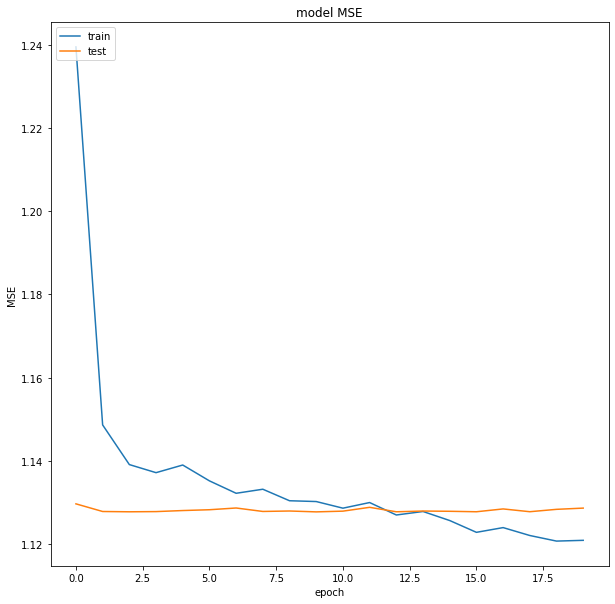

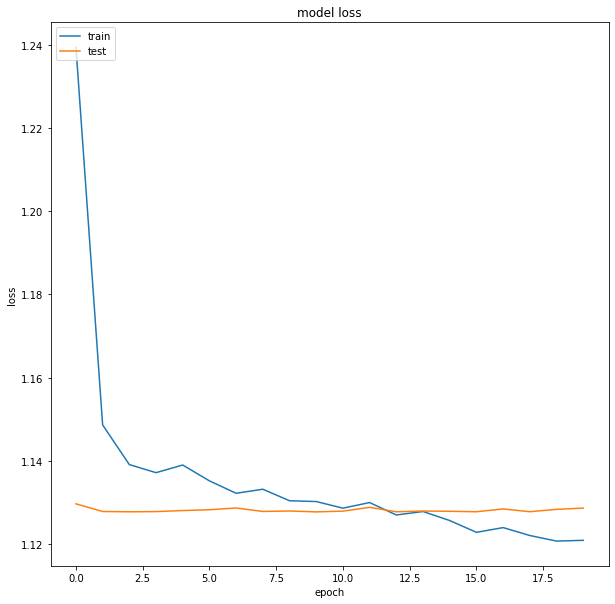

In [382]:

# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")